K Bala Sai Manvitha - CS22B1030

In [3]:
# Load the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [4]:
import os

os.listdir(path)

['kaggle_3m', 'lgg-mri-segmentation']

In [5]:
path = os.path.join(path, 'kaggle_3m')

In [12]:
import numpy as np
from PIL import Image
import cv2

X = []
Y = []

imgWidth = 128
imgHeight = 128

# For each patient foldef
for patientFolder in os.listdir(path):
    patientPath = os.path.join(path, patientFolder)

    # No path was found
    if not os.path.isdir(patientPath):
        continue

    for file in os.listdir(patientPath):
        if file.endswith(".tif") and "_mask" not in file:
            imgPath = os.path.join(patientPath, file)
            maskPath = os.path.join(patientPath, file.replace(".tif", "_mask.tif"))

            # Load Img and mask
            img = np.array(Image.open(imgPath))
            mask = np.array(Image.open(maskPath))

            # Extract Flair channel
            flairImg = img[:, :, 1]

            # Resize Img and mask
            flairImg = cv2.resize(flairImg, (imgWidth, imgHeight), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (imgWidth, imgHeight), interpolation = cv2.INTER_NEAREST)

            # Normilize and binarize
            flairImg = flairImg / 255.0
            mask = mask/255.0
            mask = (mask > 0.5).astype(np.float32)

            # add channel dimention
            flairImg = np.expand_dims(flairImg, axis = -1)
            mask = np.expand_dims(mask, axis = -1)

            X.append(flairImg)
            Y.append(mask)

# Convert to np arrays
X = np.array(X, dtype = np.float32)
Y = np.array(Y, dtype = np.float32)

print("Image Shape: ", X.shape)
print("Mask Shape: ", Y.shape)

Image Shape:  (3929, 128, 128, 1)
Mask Shape:  (3929, 128, 128, 1)


In [13]:
from sklearn.model_selection import train_test_split

xTrain, xTemp, yTrain, yTemp = train_test_split(X, Y, test_size = 0.2, random_state = 42)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size = 0.5, random_state = 42)

In [16]:
print("Train:", xTrain.shape, "Val:", xVal.shape, "Test:", xTest.shape)

Train: (3143, 128, 128, 1) Val: (393, 128, 128, 1) Test: (393, 128, 128, 1)


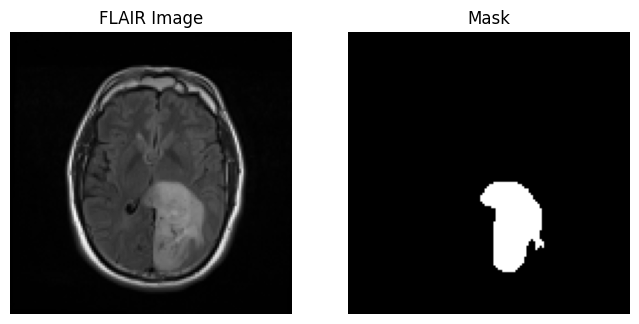

In [15]:
import matplotlib.pyplot as plt

def visualize(idx=0):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(xTrain[idx].squeeze(), cmap='gray')
    plt.title("FLAIR Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(yTrain[idx].squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis("off")
    plt.show()

visualize(0)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Defining the model
def unetModel(inputShape = (128, 128, 1)):
    inputs = layers.Input(inputShape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c2])      # Skip Connections
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D()(c4)
    u1 = layers.concatenate([u1, c1])      # Skip Connections
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)

In [18]:
model = unetModel()

In [19]:
# Metrics
def diceCoefficient(yTrue, yPred, smooth = 1e-6):
    yTrueF = tf.keras.backend.flatten(yTrue)
    yPredF = tf.keras.backend.flatten(yPred)
    intersection = tf.keras.backend.sum(yTrueF*yPredF)

    return (2. * intersection+smooth) / (tf.keras.backend.sum(yTrueF) + tf.keras.backend.sum(yPredF) + smooth)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', diceCoefficient])

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 96)     │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 32)     │         27,680 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 32)   │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 48)   │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 16)   │          6,928 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [23]:
history = model.fit(
    xTrain, yTrain,
    validation_data=(xVal, yVal),
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9895 - dice_coefficient: 0.0532 - loss: 0.1435 - val_accuracy: 0.9909 - val_dice_coefficient: 0.1682 - val_loss: 0.0349
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9900 - dice_coefficient: 0.1559 - loss: 0.0341 - val_accuracy: 0.9918 - val_dice_coefficient: 0.1864 - val_loss: 0.0290
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 193s 981ms/step - accuracy: 0.9911 - dice_coefficient: 0.1869 - loss: 0.0312 - val_accuracy: 0.9901 - val_dice_coefficient: 0.2667 - val_loss: 0.0295
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9910 - dice_coefficient: 0.2785 - loss: 0.0296 - val_accuracy: 0.9930 - val_dice_coefficient: 0.3211 - val_loss: 0.0233
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9919 - dice_coefficient: 0.3258 - loss: 0.0265 - val_accuracy: 0.9926 - val_dice_coefficient: 0.3145 - val_loss: 0.0227
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 193s 979ms/step - accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.9964 - dice_coefficient: 0.7747 - loss: 0.0110
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step


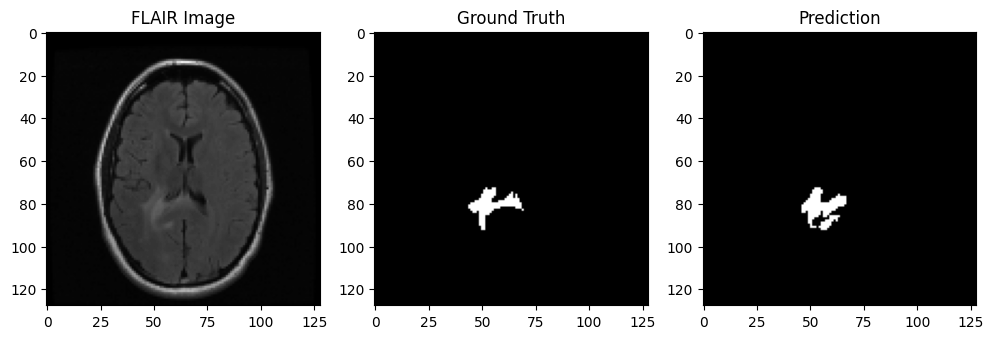

In [25]:
model.evaluate(xTest, yTest)

# Predict and visualize
preds = model.predict(xTest)

def show_prediction(index):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(xTest[index].squeeze(), cmap='gray')
    plt.title("FLAIR Image")

    plt.subplot(1, 3, 2)
    plt.imshow(yTest[index].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow((preds[index] > 0.5).squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.show()

show_prediction(0)


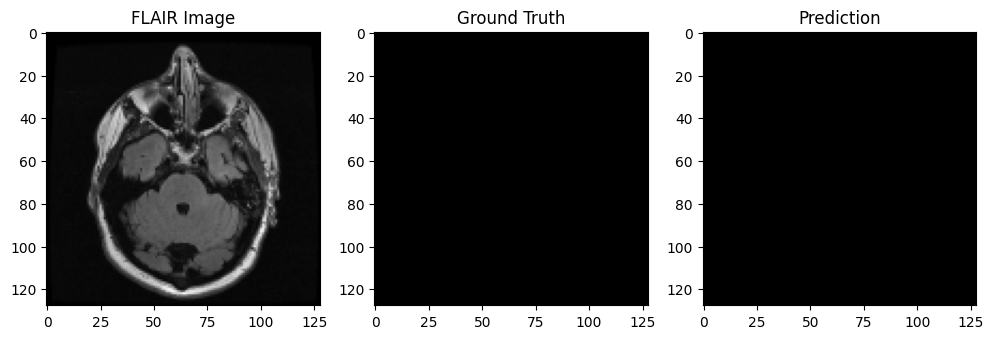

In [27]:
show_prediction(2)


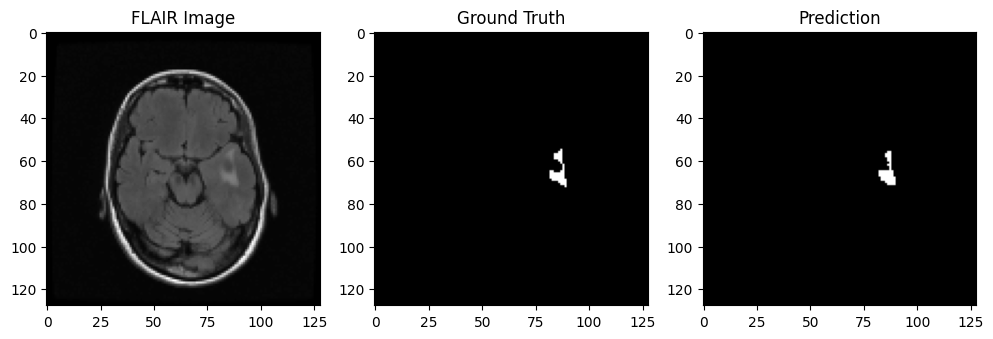

In [29]:
show_prediction(10)

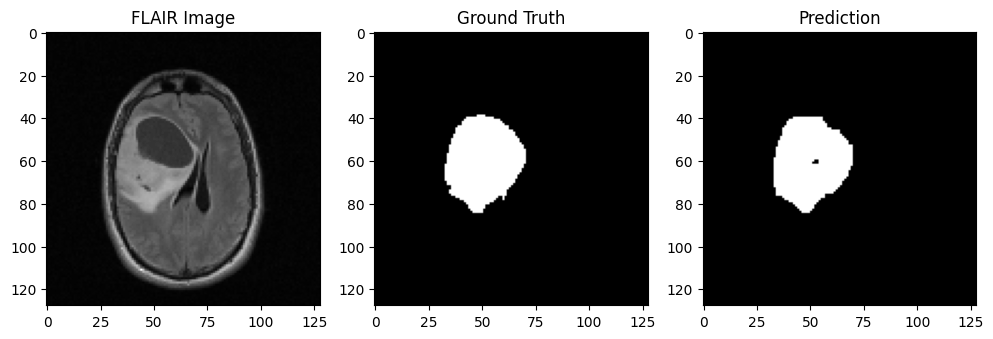

In [30]:
show_prediction(37)


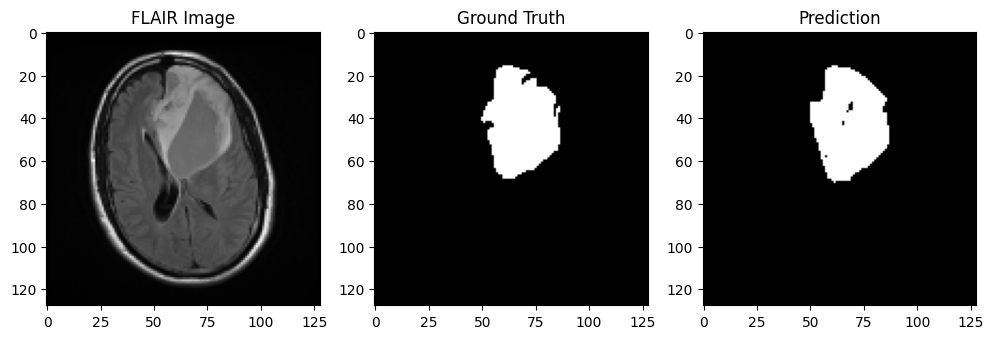

In [34]:
show_prediction(79)